# Project Name : Credit Card Fraud Detection using TPOT

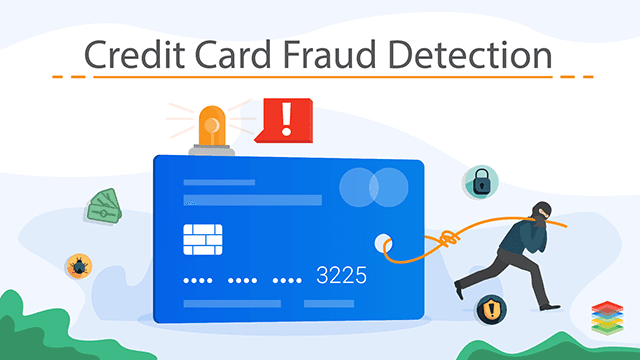

#### In this project we will be first making our redictions using Machine Learning Techniques then we will be using Auto ML Technique to do the same. We will be using PyCaret in this notebook 

## Context 
### It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase

### In this project we will be implementing Anamoly detection to detect wheteher there is any fraudulent transaction.

## Content
### The dataset contains transactions made by credit cards in September 2013 by European cardholders.
### This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

### It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

### Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

## In this notebook we will perform the following task: 
- Data Analysis
- Feature Engineering
- Model Building and Prediction using ML Techniques
- Model Building and Prediction using PyCaret(Auto ML)

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import scipy
from sklearn.metrics import classification_report,accuracy_score

### Importing Libraries for Outlier Detection

In [2]:
from sklearn.ensemble import IsolationForest

from sklearn.svm import OneClassSVM

### Reading our Dataset

In [3]:
df= pd.read_csv("creditcard.csv")

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Data Analysis

In [5]:
df.shape

(284807, 31)

#### Checking Null Values

In [6]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

### Checking the distribution of Normal and Fraud cases in our Data Set

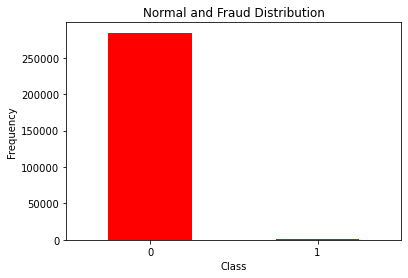

In [7]:
fraud_check = pd.value_counts(df['Class'], sort = True)
fraud_check.plot(kind = 'bar', rot=0, color= 'r')
plt.title("Normal and Fraud Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")
 ## Defining labels to replace our 0 and 1 valuelabels= ['Normal','Fraud']
## mapping those labels
plt.xticks(range(2))
plt.show()


#### Let us see what is the shape of Normal and Fraud data set

In [8]:
fraud_people = df[df['Class']==1]
normal_people = df[df['Class']==0]

In [9]:
fraud_people.shape

(492, 31)

In [10]:
normal_people.shape

(284315, 31)

#### Finding out the avg amount in our both the data sets

In [11]:
fraud_people['Amount'].describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [12]:
normal_people['Amount'].describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

#### Let us analyse it visually

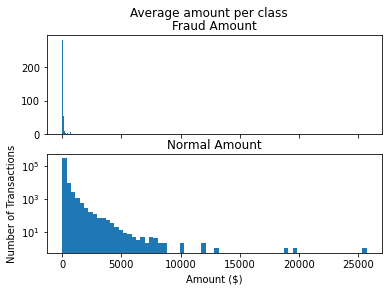

In [13]:
graph, (plot1, plot2) = plt.subplots(2,1,sharex= True)
graph.suptitle('Average amount per class')
bins = 70

plot1.hist(fraud_people['Amount'] , bins = bins)
plot1.set_title('Fraud Amount')

plot2.hist(normal_people['Amount'] , bins = bins)
plot2.set_title('Normal Amount')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show();

#### Plotting a corr Heatmap

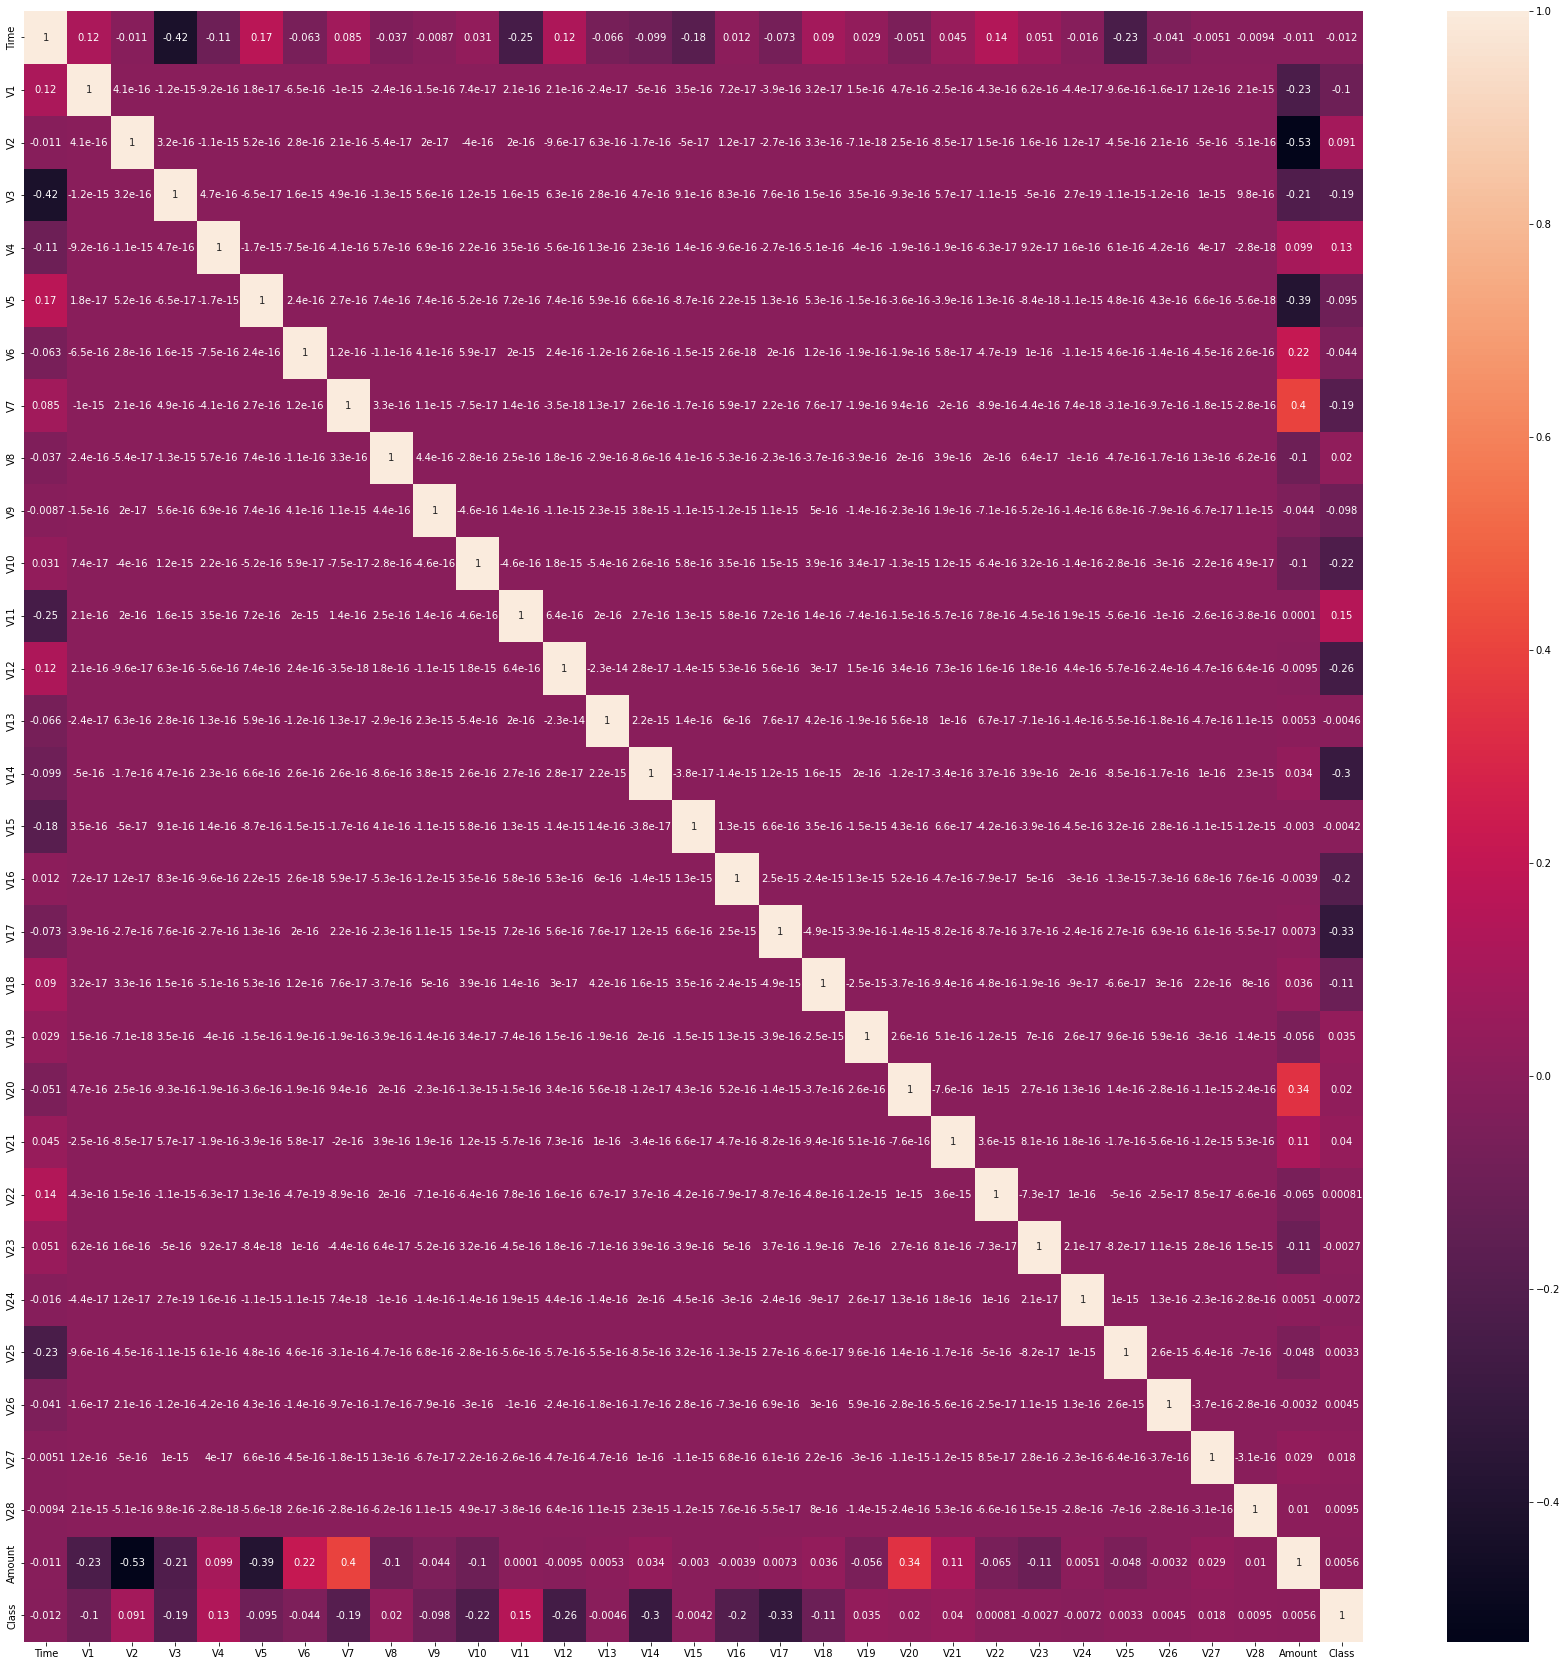

In [14]:
df.corr()
plt.figure(figsize=(30,30))
g=sns.heatmap(df.corr(),annot=True)

### Creating our Dependent and Independent Features

In [15]:
columns = df.columns.tolist()
# Making our Independent Features
columns = [var for var in columns if var not in ["Class"]]
# Making our Dependent Variable
target = "Class"
x= df[columns]
y= df[target]

In [16]:
x.shape

(284807, 30)

In [17]:
y.shape

(284807,)

In [18]:
x.head() ## Independent Variable

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


In [19]:
y.head() ## Dependent Variable

0    0
1    0
2    0
3    0
4    0
Name: Class, dtype: int64

## Model building

### Splitting the data

In [20]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

### We wil be using the following Models for our Anamoly Detection:
- Isolation Forest
- OneClassSVM

## Isolation Forest

#### One of the newest techniques to detect anomalies is called Isolation Forests. The algorithm is based on the fact that anomalies are data points that are few and different. As a result of these properties, anomalies are susceptible to a mechanism called isolation.

#### This method is highly useful and is fundamentally different from all existing methods. It introduces the use of isolation as a more effective and efficient means to detect anomalies than the commonly used basic distance and density measures. Moreover, this method is an algorithm with a low linear time complexity and a small memory requirement. It builds a good performing model with a small number of trees using small sub-samples of fixed size, regardless of the size of a data set.

#### Typical machine learning methods tend to work better when the patterns they try to learn are balanced, meaning the same amount of good and bad behaviors are present in the dataset.

#### How Isolation Forests Work The Isolation Forest algorithm isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. The logic argument goes: isolating anomaly observations is easier because only a few conditions are needed to separate those cases from the normal observations. On the other hand, isolating normal observations require more conditions. Therefore, an anomaly score can be calculated as the number of conditions required to separate a given observation.

#### The way that the algorithm constructs the separation is by first creating isolation trees, or random decision trees. Then, the score is calculated as the path length to isolate the observation

In [21]:
iso_forest= IsolationForest(n_estimators=100, 
                            max_samples=len(x_train),
                            random_state=0, 
                            verbose=0)                        

In [22]:
iso_forest.fit(x_train,y_train)

IsolationForest(max_samples=199364, random_state=0)

In [23]:
ypred= iso_forest.predict(x_test)

In [24]:
ypred

array([-1,  1,  1, ...,  1,  1,  1])

#### Mapping the values as we want to have an output in 0 and 1

In [25]:
ypred[ypred == 1] = 0
ypred[ypred == -1] = 1

### Accuracy score and Matrix

In [26]:
print(accuracy_score(y_test,ypred))

0.9978465175614152


In [27]:
print(classification_report(y_test,ypred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.37      0.51      0.43       136

    accuracy                           1.00     85443
   macro avg       0.69      0.76      0.72     85443
weighted avg       1.00      1.00      1.00     85443



In [28]:
from sklearn.metrics import confusion_matrix

In [29]:
confusion_matrix(y_test, ypred)

array([[85189,   118],
       [   66,    70]], dtype=int64)

### We can also print how many errors our model have

In [30]:
n_errors = (ypred != y_test).sum()
print("Isolation Forest have {} errors.".format(n_errors))

Isolation Forest have 184 errors.


### Accuracy score and Matrix

In [31]:
print(accuracy_score(y_test,ypred))

0.9978465175614152


In [32]:
print(classification_report(y_test,ypred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.37      0.51      0.43       136

    accuracy                           1.00     85443
   macro avg       0.69      0.76      0.72     85443
weighted avg       1.00      1.00      1.00     85443



In [33]:
from sklearn.metrics import confusion_matrix

In [34]:
confusion_matrix(y_test, ypred)

array([[85189,   118],
       [   66,    70]], dtype=int64)

In [35]:
n_errors = (ypred != y_test).sum()
print("ISOFOre have {} errors.".format(n_errors))

ISOFOre have 184 errors.


## Solving the Problem Statement using TPOT(Auto ML)

# TPOT :

![TPOTworking.png](https://iq.opengenus.org/content/images/2019/11/0_iYQTbI4WVGUF1_F1.png)

### TPOT stands for Tree Base Pipeline Optimization Tool. It is used to solve or give a idea on machine learning problems. It helps us to explore some of pipeline confiuration that we did not consider earlier for our model. It helps us to find out best algorithm for the problem we are working on. We feed the data which is the train input and train output. It analyzes the data and tell us the best machine learning model for the purpose.

![TPOTdataset.png](https://iq.opengenus.org/content/images/2019/11/0_vqs4500HEIa4eN4D.png)

### Installing Pycaret

In [36]:
import tpot

C:\Users\sadpa\anaconda3\envs\pyspark\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [37]:
df= pd.read_csv("creditcard.csv")

In [38]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [39]:
train=df.drop('Class',axis=1)
test=df['Class']

from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
train=sc.fit_transform(train)

from sklearn import model_selection
x_train,x_test,y_train,y_test=model_selection.train_test_split(train,test)

In [40]:
from tpot import TPOTClassifier
from sklearn.metrics import roc_auc_score

In [41]:
pot = TPOTClassifier(
    generations=3,
    population_size=10,
    verbosity=2,
    scoring='roc_auc',
    random_state=42,
    disable_update_check=True,
    config_dict='TPOT light', 
    n_jobs=-1
)
pot.fit(x_train, y_train)

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9700129109204093

Generation 2 - Current best internal CV score: 0.9704094789758273

Generation 3 - Current best internal CV score: 0.9704094789758273

Generation 4 - Current best internal CV score: 0.9732654942258128

Generation 5 - Current best internal CV score: 0.9789885582732347

Best pipeline: LogisticRegression(input_matrix, C=0.001, dual=False, penalty=l2)


TPOTClassifier(config_dict='TPOT light', disable_update_check=True,
               generations=5, n_jobs=-1, population_size=20, random_state=42,
               scoring='roc_auc', verbosity=2)

In [42]:
tpot_auc_score = roc_auc_score(y_test, pot.predict_proba(x_test)[:, 1])
print(f'\nAUC score: {tpot_auc_score:.4f}')


AUC score: 0.9880


In [43]:
print('\nBest pipeline steps:', end='\n')
for idx, (name, transform) in enumerate(pot.fitted_pipeline_.steps, start=1):
    print(f'{idx}. {transform}')


Best pipeline steps:
1. LogisticRegression(C=0.001, random_state=42)


In [44]:
ypred = pot.predict(x_test)
print(classification_report(y_test,ypred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71093
           1       0.83      0.48      0.60       109

    accuracy                           1.00     71202
   macro avg       0.91      0.74      0.80     71202
weighted avg       1.00      1.00      1.00     71202

